Xarray processing stream for ERA5 netcdf files
Written by: Matt Jolly
Date: 24 July 2019

In [176]:
%matplotlib inline
import math
import xarray as xr
from dask.diagnostics import ProgressBar
import numpy as np
import pandas as pd
import netCDF4
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [177]:
# Basic file path to NetCDF data files
fpath = '/run/media/mjolly/BigFire/projects/era5/data'
# Air temperature file
t2m = 'era5_single_levels_t2m_2018.nc'
t2mfullpath = "%s/%s" % (fpath,t2m)
# Dewpoint temperature file
tdew = 'era5_single_levels_2m_dewpoint_temperature_2018.nc'
tdewfullpath = "%s/%s" % (fpath,tdew)
ofile = tdewfullpath.replace("era5_single_levels_t2m_","era5_2m_daily_relative_humidity_")
print(t2mfullpath)
ds_t2m = xr.open_dataset(t2mfullpath,chunks={'time': 20})
ds_tdew = xr.open_dataset(tdewfullpath,chunks={'time': 20})

/run/media/mjolly/BigFire/projects/era5/data/era5_single_levels_t2m_2018.nc


In [178]:
ds_t2m
ds_tdew
ds_tdew.d2m.attrs

OrderedDict([('units', 'K'), ('long_name', '2 metre dewpoint temperature')])

In [179]:
t2mvp = np.exp(1.81 + (ds_t2m.t2m * 17.27 - 4717.31) / (ds_t2m.t2m - 35.86))
tdewvp = np.exp(1.81 + (ds_tdew.d2m * 17.27 - 4717.31) / (ds_tdew.d2m - 35.86))
rh = (tdewvp / t2mvp) * 100

In [202]:
# Create an output dataset with all attributes
outds = ds_t2m
outds = outds.drop('t2m')
outds.attrs['Desc'] = "Derived from 2m air temperature and 2m dewpoint temperature from ERA5"
rh.attrs['units'] = "%"
rh.attrs['long_name'] = "2 metre relative humidity"
outds['rh'] = rh
outds = outds.groupby('time.dayofyear').mean('time')
outds.to_netcdf("/run/media/mjolly/BigFire/projects/era5/data/testout.nc",format= 'NETCDF4_CLASSIC' )
outds

<xarray.Dataset>
Dimensions:    (dayofyear: 365, latitude: 721, longitude: 1440)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
Data variables:
    rh         (dayofyear, latitude, longitude) float32 dask.array<shape=(365, 721, 1440), chunksize=(1, 721, 1440)>

(array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]),
 array([ 74.09676361,  74.19676361,  74.29676361,  74.39676361,
         74.49676361,  74.59676361,  74.69676361,  74.79676361,
         74.89676361,  74.99676361,  75.09676361]),
 <a list of 10 Patch objects>)

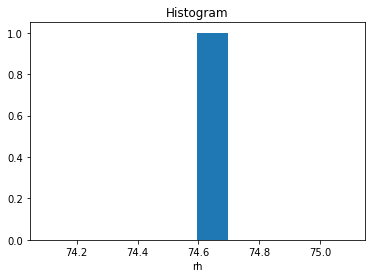

In [204]:
outds.rh.sel(dayofyear=slice('180','240')).mean().shift(longitude=720).plot()

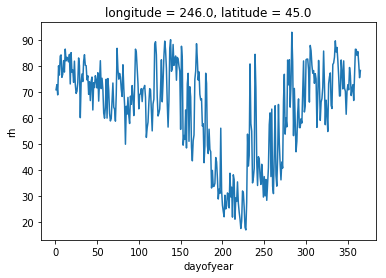

In [181]:
#Aggregate grid from hourly to daily
r = outds.rh.groupby('time.dayofyear').mean('time')

# Plot a time series by lat / lon
r.sel(latitude=45, longitude=360-114, method='nearest', tolerance=5).plot()

In [182]:
def CalcVP(TempK):
    # Purpose: Calculate the sautration vapor pressure
    return np.exp(1.81 + (TempK * 17.27 - 4717.31) / (TempK - 35.86))

def CalcVP_XR(a):
    return xr.apply_ufunc(CalcVP, a,keep_attrs=True,dask='parallelized')

#with ProgressBar():
#    ds.load()

In [184]:
def CVP(TempK):
    func = lambda x: np.exp(1.81 + (x* 17.27 - 4717.31) / (x- 35.86))
    return xr.apply_ufunc(func,TempK,dask='parallelized',output_dtypes=[float])

In [105]:
ds_sub = ds.sel(time=slice('2018-07-01','2018-07-15'))
ds_sub = ds

In [185]:
tempvp = CVP(ds_t2m.t2m )

In [74]:
ds_sub = math.exp(1.81 + (ds_sub.t2m * 17.27 - 4717.31) / (ds_sub.t2m - 35.86))

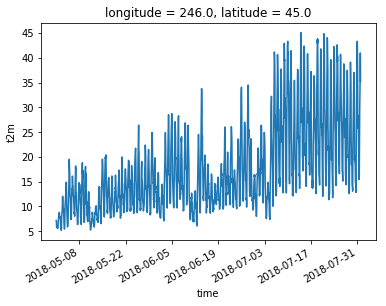

In [196]:
#tempvp.sel(time=slice('2018-07-01','2018-07-15')).mean().plot()
tempvp.sel(time=slice('2018-05-01','2018-07-31')).sel(latitude=45, longitude=360-114, method='nearest', tolerance=5).plot()

In [76]:
d = ds_sub.max(dim='time')

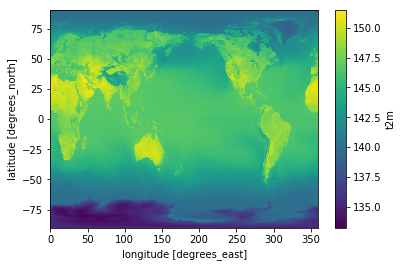

In [78]:
d.plot()

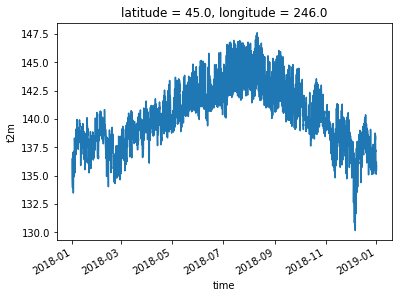

In [100]:
ds_sub.sel(latitude=45, longitude=360-114, method='nearest', tolerance=5).plot()


In [108]:
ds_sub.t2m.attrs

OrderedDict([('units', 'K'), ('long_name', '2 metre temperature')])

In [128]:
from netCDF4 import Dataset
dataset = Dataset(t2mfullpath) 
print (dataset.file_format )
print (dataset.dimensions.keys)
print (dataset.dimensions)
print (dataset.variables)

NETCDF3_64BIT_OFFSET
<built-in method keys of collections.OrderedDict object at 0x7efb903ecc80>
OrderedDict([('longitude', <class 'netCDF4._netCDF4.Dimension'>: name = 'longitude', size = 1440
), ('latitude', <class 'netCDF4._netCDF4.Dimension'>: name = 'latitude', size = 721
), ('time', <class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 8760
)])
OrderedDict([('longitude', <class 'netCDF4._netCDF4.Variable'>
float32 longitude(longitude)
    units: degrees_east
    long_name: longitude
unlimited dimensions: 
current shape = (1440,)
filling on, default _FillValue of 9.969209968386869e+36 used
), ('latitude', <class 'netCDF4._netCDF4.Variable'>
float32 latitude(latitude)
    units: degrees_north
    long_name: latitude
unlimited dimensions: 
current shape = (721,)
filling on, default _FillValue of 9.969209968386869e+36 used
), ('time', <class 'netCDF4._netCDF4.Variable'>
int32 time(time)
    units: hours since 1900-01-01 00:00:00.0
    long_name: time
    calendar: gregorian
unli

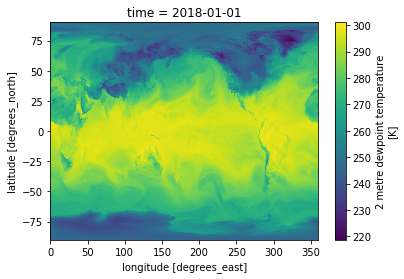

In [134]:
ds_tdew.d2m.isel(time=0).plot()

In [192]:
print(CalcVP(290))


19.2017000531
